## This notebook shows how to use GPFlow to approximate functions

In [1]:
import tensorflow as tf
import gpflow as gp
gp.config.set_default_summary_fmt("notebook")
import numpy as np
from matplotlib import pyplot as plt

### 1D example

In [2]:
def f(x):
    return x ** 2

# generate training data
Ntrain = 200
Ntest1 = 50
Ntest2 = 500
Ntest3 = 2000

X_train = np.random.rand(Ntrain, 1)
Y_train = f(X_train)

X_test1 = np.random.rand(Ntest1, 1)
Y_test1 = f(X_test1)

X_test2 = np.random.rand(Ntest2, 1)
Y_test2 = f(X_test2)

X_test3 = np.random.rand(Ntest3, 1)
Y_test3 = f(X_test3)

#### a) without `@tf.function`

In [3]:
approx = gp.models.GPR(data=(X_train, Y_train), kernel=gp.kernels.SquaredExponential(), mean_function=None)
gp.utilities.print_summary(approx)
# optimize hp
optimizer = gp.optimizers.Scipy()
optimizer.minimize(approx.training_loss, approx.trainable_variables, options=dict(maxiter=100))
gp.utilities.print_summary(approx)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,562.868
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.72068
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


In [4]:
# make predictions
Y_train_approx, var_train_approx = approx.predict_f(X_train)
Y_test1_approx, var_test1_approx = approx.predict_f(X_test1)
Y_test2_approx, var_test2_approx = approx.predict_f(X_test2)
Y_test3_approx, var_test3_approx = approx.predict_f(X_test3)


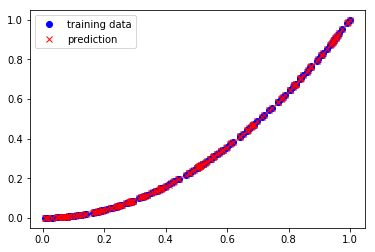

In [5]:
plt.plot(X_train[:, 0], Y_train[:, 0], 'bo', label = 'training data')
plt.plot(X_train[:, 0], Y_train_approx[:, 0], 'rx', label = 'prediction')
plt.legend()
plt.show()

In [6]:
# measure timings
print('Create model:')
%timeit gp.models.GPR(data=(X_train, Y_train), kernel=gp.kernels.SquaredExponential(), mean_function=None)
print('Optimize hps:')
%timeit optimizer.minimize(approx.training_loss, approx.trainable_variables, options=dict(maxiter=100))
print('Predict test1:')
%timeit approx.predict_f(X_test1)
print('Predict test2:')
%timeit approx.predict_f(X_test2)
print('Predict test3:')
%timeit approx.predict_f(X_test3)

Create model:
100 loops, best of 3: 12.7 ms per loop
Optimize hps:
1 loop, best of 3: 294 ms per loop
Predict test1:
100 loops, best of 3: 14.4 ms per loop
Predict test2:
10 loops, best of 3: 19.5 ms per loop
Predict test3:
10 loops, best of 3: 31.7 ms per loop


### b) now using `@tf.function`
For convenience I use the class implemented in `new_approximators.py`, it also normalizes and other things, but thats not the point. The point is that the `_predict` and `_predict_with_var` methods are decorated. Here the hp's are always optimized when the model is created. We can measure a significant speedup for prediction.

In [7]:
from new_approximators import GPflow_norm

In [8]:
# measure timings
approx_tf = GPflow_norm(X_train, Y_train, kernel_name = 'RBF')
print('Create model and optimize hps:')
%timeit GPflow_norm(X_train, Y_train, kernel_name = 'RBF')
print('Predict test1:')
%timeit approx_tf.predict_with_var(X_test1)
print('Predict test2:')
%timeit approx_tf.predict_with_var(X_test2)
print('Predict test3:')
%timeit approx_tf.predict_with_var(X_test3)

Create model and optimize hps:
1 loop, best of 3: 361 ms per loop
Predict test1:
The slowest run took 550.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.77 ms per loop
Predict test2:
The slowest run took 41.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 4.9 ms per loop
Predict test3:
The slowest run took 18.20 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 16 ms per loop


## 2D Example

In [9]:
def f(x):
    return x[:, 0:1] ** 2 + 0.4 * (x[:, 1:2] - 0.5) ** 3.

# generate training data
Ntrain = 200
Ntest1 = 50
Ntest2 = 500
Ntest3 = 2000

X_train = np.random.rand(Ntrain, 2)
Y_train = f(X_train)

X_test1 = np.random.rand(Ntest1, 2)
Y_test1 = f(X_test1)

X_test2 = np.random.rand(Ntest2, 2)
Y_test2 = f(X_test2)

X_test3 = np.random.rand(Ntest3, 2)
Y_test3 = f(X_test3)

#### a) without `@tf.function`

In [10]:
# note that we have to pass the array as lengthscales argument if we want non-isotropic lengthscales
approx = gp.models.GPR(data=(X_train, Y_train), kernel=gp.kernels.SquaredExponential(lengthscales = np.array([1., 1.])), mean_function=None)
gp.utilities.print_summary(approx)
# optimize hp
optimizer = gp.optimizers.Scipy()
optimizer.minimize(approx.training_loss, approx.trainable_variables, options=dict(maxiter=100))
gp.utilities.print_summary(approx)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1. 1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2696.007281572945
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[9.2547561 4.99937864]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


In [11]:
# make predictions
Y_train_approx, var_train_approx = approx.predict_f(X_train)
Y_test1_approx, var_test1_approx = approx.predict_f(X_test1)
Y_test2_approx, var_test2_approx = approx.predict_f(X_test2)
Y_test3_approx, var_test3_approx = approx.predict_f(X_test3)


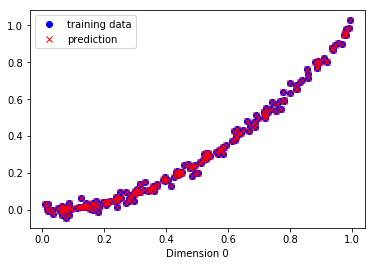

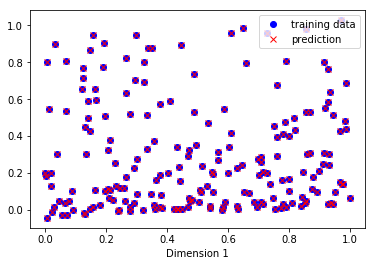

In [12]:
plt.plot(X_train[:, 0], Y_train[:, 0], 'bo', label = 'training data')
plt.plot(X_train[:, 0], Y_train_approx[:, 0], 'rx', label = 'prediction')
plt.xlabel('Dimension 0')
plt.legend()
plt.show()

plt.plot(X_train[:, 1], Y_train[:, 0], 'bo', label = 'training data')
plt.plot(X_train[:, 1], Y_train_approx[:, 0], 'rx', label = 'prediction')
plt.xlabel('Dimension 1')
plt.legend()
plt.show()

In [13]:
# measure timings
print('Create model:')
%timeit gp.models.GPR(data=(X_train, Y_train), kernel=gp.kernels.SquaredExponential(), mean_function=None)
print('Optimize hps:')
%timeit optimizer.minimize(approx.training_loss, approx.trainable_variables, options=dict(maxiter=100))
print('Predict test1:')
%timeit approx.predict_f(X_test1)
print('Predict test2:')
%timeit approx.predict_f(X_test2)
print('Predict test3:')
%timeit approx.predict_f(X_test3)

Create model:
100 loops, best of 3: 12.9 ms per loop
Optimize hps:
1 loop, best of 3: 237 ms per loop
Predict test1:
100 loops, best of 3: 15.6 ms per loop
Predict test2:
10 loops, best of 3: 20.6 ms per loop
Predict test3:
10 loops, best of 3: 32.7 ms per loop


### b) now using `@tf.function`

In [14]:
# measure timings
approx_tf = GPflow_norm(X_train, Y_train, kernel_name = 'RBF')
print('Create model and optimize hps:')
%timeit GPflow_norm(X_train, Y_train, kernel_name = 'RBF')
print('Predict test1:')
%timeit approx_tf.predict_with_var(X_test1)
print('Predict test2:')
%timeit approx_tf.predict_with_var(X_test2)
print('Predict test3:')
%timeit approx_tf.predict_with_var(X_test3)

Create model and optimize hps:
1 loop, best of 3: 563 ms per loop
Predict test1:
The slowest run took 100.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.99 ms per loop
Predict test2:
The slowest run took 51.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 4.58 ms per loop
Predict test3:
The slowest run took 19.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 17.8 ms per loop
